**In this file**, we derive predictions for the population risk when running single shuffle SGD on a least squares problem, and we compare it to random shuffle and streaming SGD.


In [ ]:
#import jax
#import jax.numpy as np
#import jax.scipy as sp
import numpy as np
import scipy as sp
import numpy.random as npr
from scipy.sparse import diags as spdiags
from scipy.sparse import linalg as splinalg
from scipy.signal import fftconvolve as fftconvolve
from scipy.integrate import quad
from scipy.integrate import fixed_quad
from scipy.integrate import solve_ivp

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pdb

In [ ]:
def sgd_lsq_ridge( A, b, t_max, ridge=0.0,
             initial_state = [], loss=lambda x: (1/2)*np.sum( (A@x-b)**2),
             gamma=-1, oversample=1, m=1.0):
  """Runs the (random shuffle) sgd algorithm to solve the least squares problem Ax=b.

  Parameters
  ----------
  A : matrix
      The data matrix (2d-array) of some shape (n,d)
  b : vector
      The target vector
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  ridge : float, optional
      The strength of the ridge regularization
  initial_state : vector, optional
      The initial state vector of the algorithm.  Defaults to
      iid Gaussian of expected norm-squared d/(2*n).
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  ridge: float, optional
      The ridge parameter to pass.
  oversample: int, optional
      return additional losses, by a multiple of oversample
      (note integer division is performed, so every n//oversample is returned)
  m: float, optional
      The adaptive step parameter.


  Returns
  -------
  x: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  times: numpy.array(int)
      the iteration counts at which the sgd was sampled
  """

  n, d = A.shape
  adaptivestep=False
  adaptivesample=True
  TL = lambda x: (1/2)*np.sum( (A@x-b)**2)

  steps = (n * t_max)#.astype(int)

  losses = []
  gammas = []
  times = []

  if (len(initial_state)==0):
    initial_state = npr.randn(d)/ (np.sqrt(2*n))
  x = initial_state

  if oversample=='adaptive':
    adaptivesample = True
    oversample = 10

  tnaught = TL(x)
  GR = lambda A,x,b,ridge, n : A * (A.dot(x) - b) + (ridge/n)*x



  for t in range(steps):
    i = npr.randint(0,n, size =1)[0]
    grad_i = GR(A[i],x,b[i],ridge,n)

    if adaptivesample:
      if t % oversample == 0:
        oversample = (oversample*11)//10
        losses.append(loss(x))
        times.append(t)
    elif t % (n//oversample) == 0:
      losses.append(loss(x))
      times.append(t)
    if (adaptivestep) and (t % n == 0):
      Gamma += gamma
      tz = TL(x)
# This adaptive stepsize is the other solution of the variational problem
#      gamma = 1./(np.exp(Gamma * (m+ridge)*0.666)*np.power(tz/tnaught,0.333))
      gamma = 2./(0.75 + np.sqrt(0.5625 + np.exp(2*Gamma * (ridge+m))*tz/tnaught))
      gammas.append(gamma)
    x = x - gamma * grad_i
  if (adaptivestep):
    return x, np.array(losses), np.array(gammas)
  return x, np.array(losses), times

In [ ]:
def ss_sgd_lsq_ridge( A, b, t_max, ridge=0.0,
             initial_state = [], loss=lambda x: (1/2)*np.sum( (A@x-b)**2),
             gamma=-1, oversample=1, m=1.0):
  """Runs the (single shuffle) sgd algorithm to solve the least squares problem Ax=b.
  As the data is assumed iid, no initial shuffle is performed.

  Parameters
  ----------
  A : matrix
      The data matrix (2d-array) of some shape (n,d)
  b : vector
      The target vector
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  ridge : float, optional
      The strength of the ridge regularization
  initial_state : vector, optional
      The initial state vector of the algorithm.  Defaults to
      iid Gaussian of expected norm-squared d/(2*n).
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  ridge: float, optional
      The ridge parameter to pass.
  oversample: int, optional
      return additional losses, by a multiple of oversample
      (note integer division is performed, so every n//oversample is returned)
  m: float, optional
      The adaptive step parameter.


  Returns
  -------
  x: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  times: numpy.array(int)
      the iteration counts at which the sgd was sampled
  """

  n, d = A.shape
  adaptivestep=False
  adaptivesample=True
  TL = lambda x: (1/2)*np.sum( (A@x-b)**2)

  steps = (n * t_max)#.astype(int)

  losses = []
  gammas = []
  times = []

  if (len(initial_state)==0):
    initial_state = npr.randn(d)/ (np.sqrt(2*n))
  x = initial_state

  if oversample=='adaptive':
    adaptivesample = True
    oversample = 10

  tnaught = TL(x)
  GR = lambda A,x,b,ridge, n : A * (A.dot(x) - b) + (ridge/n)*x



  for t in range(steps):
    i = t % n
    #i = npr.randint(0,n, size =1)[0]
    grad_i = GR(A[i],x,b[i],ridge,n)

    if adaptivesample:
      if t % oversample == 0:
        oversample = (oversample*11)//10
        losses.append(loss(x))
        times.append(t)
    elif t % (n//oversample) == 0:
      losses.append(loss(x))
      times.append(t)
    if (adaptivestep) and (t % n == 0):
      Gamma += gamma
      tz = TL(x)
# This adaptive stepsize is the other solution of the variational problem
#      gamma = 1./(np.exp(Gamma * (m+ridge)*0.666)*np.power(tz/tnaught,0.333))
      gamma = 2./(0.75 + np.sqrt(0.5625 + np.exp(2*Gamma * (ridge+m))*tz/tnaught))
      gammas.append(gamma)
    x = x - gamma * grad_i
  if (adaptivestep):
    return x, np.array(losses), np.array(gammas)
  return x, np.array(losses), times

In [ ]:
def s_sgd_lsq_ridge( dtpair, steps, ridge=0.0,
             initial_state = [], loss=lambda x: (1/2)*np.sum( (x)**2),
             gamma=-1, oversample=1, m=1.0):
  """Runs the sgd algorithm to solve the least squares problem Ax=b.
  The special case of gamma_1 =0 recovers SGD.

  Parameters
  ----------
  dtpair : function
      This should return a pair (a, b) of training data
  steps : int
      The number of iterations to run
  ridge : float, optional
      The strength of the ridge regularization (per iteration)
  initial_state : vector, optional
      The initial state vector of the algorithm.  Defaults to
      iid Gaussian of expected norm-squared d/(2*n).
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  ridge: float, optional
      The ridge parameter to pass.
  oversample: int, optional
      return additional losses, by a multiple of oversample
      (note integer division is performed, so every d//oversample is returned).
      Pass 'adaptive' for adaptive scheme.


  Returns
  -------
  x: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  times: numpy.array(int)
      the iteration counts at which the sgd was sampled
  """

  a = dtpair()[0]
  d = len(a)
  adaptivesample=False
  #TL = lambda x: (1/2)*np.sum( (A@x-b)**2)

  losses = []
  gammas = []
  times = []

  if (len(initial_state)==0):
    initial_state = npr.randn(d)/ (np.sqrt(2*d))
  x = initial_state

  if oversample=='adaptive':
    adaptivesample = True
    oversample = 1

  GR = lambda A,x,b,ridge : A * (A.dot(x) - b) + ridge*x



  for t in range(steps):
    a,b = dtpair()
    grad_i = GR(a,x,b,ridge)

    if adaptivesample:
      if t % oversample == 0:
        oversample += 10
        losses.append(loss(x))
        times.append(t)
    elif t % (d//oversample) == 0:
      losses.append(loss(x))
      times.append(t)

    x = x - gamma * grad_i

  return x, np.array(losses), times

In [ ]:
def picard_volterra(f, K, t_max, n_grid):
  """Runs Picard iteration to approximate a convolution Volterra equation
  sol = f + K*sol, where * denotes convolution,
  and where K is assumed to be positive.

  Parameters
  ----------
  f : callable
      Forcing function that takes as input a vector of times to be evaluated
  K : callable
      Convolution kernel that takes as input a vector of times to be evaluated
  t_max : float
      The number of epochs
  n_grid : int
      The number of grid points

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """

  t_grid = tf.linspace(0, t_max, n_grid)
  delta = t_max/n_grid
  I = delta*K(t_grid)
  F = f(t_grid)

  danger =  tf.reduce_max(I).numpy()
  if danger > 0.001:
    print("Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is " + str(danger))


  #tf.reduce_sum()
  knorm = tf.reduce_sum(I).numpy()
  print( "kernel norm computed as "+str(knorm))

  loops = int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  sol = tf.zeros(n_grid, dtype=tf.float64)
  for i in range(loops):
    sol = F + fftconvolve(sol, I, mode="full")[0:n_grid]
  return t_grid, sol


In [ ]:
from gc import is_tracked
def tf_empirical_volterra_sgd(eiglist, t_max, n_grid, initial_state, UTb, ridge = 0.0, gamma=-1):
  """Generates the Volterra model for SGD for a list of eigenvalues eiglist

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T).
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of
      the eigenvalues

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n_eig= len(eiglist)

  if gamma==-1:
    gamma = len(eiglist)/np.sum(eiglist)


  n = n_eig
  d = len(initial_state)
  r=min(n,d)

  tfeig = tf.constant(eiglist[0:r], dtype=tf.float64)
  tfUTb = tf.constant(UTb[0:r], dtype=tf.float64)
  tfIS = tf.constant(initial_state[0:r], dtype=tf.float64)

  def forcing(times):
    tftimes = tf.constant(times, dtype=tf.float64)
    eigtimes = (tf.tensordot(-1.0*gamma*(tfeig+ridge),tftimes,axes=0))

    ftally = tf.einsum('i,i,ij', 0.5*(tfIS**2),tfeig, tf.math.exp(2.0*eigtimes))
    pt=tf.einsum('i,ij->ij', tfeig/(tfeig+ridge), 1.0-tf.math.exp(eigtimes))
    ftally += 0.5*tf.reduce_sum(tf.einsum('i,ij->ij', (tfUTb),pt-1.0)**2,axis=0)

    if n > d:
      ftally += (0.5*np.sum(UTb[-(n-d):]**2))
    return ftally

  def K(t):
    tft = tf.constant(t, dtype=tf.float64)
    et = (tf.tensordot(-2.0*gamma*(tfeig+ridge),tft,axes=0))
    return tf.einsum('i,ij', (gamma**2/n)*tfeig**2, tf.math.exp(et))

  t_grid, sol = picard_volterra(forcing,K,t_max,n_grid)


  return t_grid, sol



Demonstrate the empirical losses of the Volterra equation with empirical eigenvalues vs sgd on random features data.

Given Gaussian vectors X (''data'') ($n \times n_0$ -- n samples of data dimension $n_0$, which are standardized), we multiply by a weight matrix W (''inner layer weights'') ($n_0 \times d$ -- un-normalized).  Then $XW$ is $n \times d$.  We apply an activation function $\psi$ to each entry of $XW$.  We assume that $\psi$ is also standarized, in that $\mathbb{E}( \psi(Z) ) =0$ and  $\mathbb{E}( \psi(Z)^2 ) = 1/d$ for $Z \sim N(0,1).$

Example (1):
The linear case is $\psi(x) = x/\sqrt{d}$.

Example (2):
The ReLU case is $\frac{(\max\{x,0\} - (1/\sqrt{2\pi}))}{\sqrt{d}\sqrt{ 1/2 - 1/(2\pi)}}$

The ground truth is a linear model $x \mapsto x^T\beta$ for $x \in \mathbb{R}^{n_0}$ and $\beta \in \mathbb{R}^{n_0}$.  We suppose that $\beta$ are iid $N(0,1)$.  Then we draw a $b = X \beta$.

The first cell below generates the sample covariance matrix and the sample mean needed to to evaluate the test error.


In [ ]:
def stdz_relu(M):
  """Generate a gaussian-mean-0, gaussian-variance-1 relu of a matrix
  Parameters
  ----------
  M : vector
      The data to be relued
  """
#  return (tf.maximum(M,0.0)-(1.0/np.sqrt(2*np.pi)))/np.sqrt(0.5 - 1.0/(2*np.pi))
  return (np.maximum(M,0.0)-(1.0/np.sqrt(2*np.pi)))/np.sqrt(0.5 - 1.0/(2*np.pi))

def ReLU_sigma_psi(W, samples=16000):
  """Generate the sample covariance matrix and the empirical mean (see eq (8))
  ----------
  W : matrix
      The weight matrix
  samples: integer or matrix
      If integer, the number of Gaussian samples. Otherwise, a standardized matrix of data
  """
  (n_0, d) = W.shape
  scov = np.zeros((d,d))
  psihat = np.zeros((n_0,d))

  if type(samples) == np.ndarray:
    Xi=samples
    samples = Xi.shape[0]
  else:
    Xi = npr.randn(samples,n_0)/np.sqrt(n_0)
  Ai = stdz_relu(Xi@W)/np.sqrt(d)
  scov = Ai.transpose()@Ai
  psihat = Xi.transpose()@Ai

  return scov/samples, psihat/samples

The routine below simulates the generalization error.  Updated to use TF routines.

In [ ]:
def tf_empirical_volterra_g_sgd(eiglist, t_max, n_grid, initial_state, UTb,
                             S,h,c,
                             ridge = 0.0, gamma=-1
                             ):
  """Generates the generalization error in the Volterra model for SGD, with parameters
  given in the spectral basis

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T), in DECREASING ORDER.
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  S,h,c: matrix,vector,float
      The S,h,c are the terms in the generalization functional, g, such that
      g(V^T x_t) = 0.5*x_t^T V S V^T x_t + h^T V^T x_t + c (see eq (104))
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of
      the eigenvalues

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the generalization error at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n = len(eiglist)
  d = len(initial_state)

  if gamma==-1:
    gamma = n/np.sum(eiglist)

  t_grid, f1 = tf_empirical_volterra_sgd(eiglist,t_max,n_grid,initial_state,UTb,ridge,gamma)
  f2=f1.numpy()

  eiglist = np.pad(eiglist, (0,max(d-n,0)))
  eiglist = eiglist[0:d]
  UTb = np.pad(UTb, (0,max(d-n,0)))
  UTb = UTb[0:d]

  tft = tf.cast(t_grid, tf.float32)
  tfeig = tf.constant(eiglist, dtype=tf.float32)
  tfUTb = tf.constant(UTb, dtype=tf.float32)
  tfIS = tf.constant(initial_state, dtype=tf.float32)
  tfS = tf.constant(S, dtype=tf.float32)

  eigtimes = (tf.tensordot(-1.0*gamma*(tfeig+ridge),tft,axes=0))

  ftally = tf.einsum('i,ij', 0.5*(tfIS**2)*tfeig, tf.math.exp(2.0*eigtimes))

  L = tf.linalg.cholesky(tfS + 1E-09*tf.eye(d,dtype=tf.float32))
  EM = tf.math.exp(eigtimes)
  SUTb = tfUTb * tf.math.sqrt(tfeig) / (tfeig + ridge+1E-09)
  EM1 = (tf.ones((d,n_grid),dtype=tf.float32) - EM)

  # ||x_0 * EM(t) * L||^2
  l1 = 0.5*tf.reduce_sum(tf.einsum('i,ij,ik', tfIS, EM, L, optimize='optimal')**2,axis=1)

  # ||SUTb^T * EM1(t) * L||^2
  l2 = 0.5*tf.reduce_sum(tf.einsum('i,ij,ik', SUTb, EM1, L, optimize='optimal')**2,axis=1)

  # SUTb^T * EM1(t) * h
  l3 = tf.einsum('i,ij,i', SUTb, EM1, h, optimize='optimal')

  #This is the convolution term, the final in (104).  We had a trapezoid rule correction.
  #igrand = np.sum([s*x*np.exp(-2*gamma*(x+ridge)*t_grid) for (s,x) in zip(np.diag(S),eiglist)],axis=0)
  igrand = tf.einsum('i,ij', tf.linalg.diag_part(tfS)*tfeig, EM**2).numpy()
  igrand = igrand * (gamma**2/n) * (t_max/(n_grid+1))
  l4 = fftconvolve(igrand, f2, mode="full")[0:n_grid] + (
      -0.5*igrand[0]*f2
      -0.5*igrand*f2[0]
  )


  gerror = l1+l2+l3+l4+c

  return t_grid, gerror


In [ ]:
from gc import is_tracked
def ss_tf_empirical_volterra_sgd(eiglist, t_max, n_grid, initial_state, beta, eta, epoch, ridge = 0.0, gamma=-1):
  """Generates the Volterra model for single shuffle SGD for a list of eigenvalues eiglist
  NOTE that for SS, the loss is the population loss!!

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T).
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  beta: vector
      The ground truth
  eta: float
      The noise level
  epoch: int
      The number of iterations before repeating data.
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of
      the eigenvalues

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n_eig= len(eiglist)

  if gamma==-1:
    gamma = len(eiglist)/np.sum(eiglist)


  #These should be equal for single shuffle to work properly
  n = n_eig
  d = len(initial_state)
  r=min(n,d)

  tfeig = tf.constant(eiglist[0:r], dtype=tf.float64)
  tfUTb = tf.constant(beta[0:r], dtype=tf.float64)
  tfIS = tf.constant(initial_state[0:r], dtype=tf.float64)

  def forcing(times):
    tftimes = tf.constant(times, dtype=tf.float64)
    eigtimes = (tf.tensordot(-1.0*gamma*(tfeig+ridge),tftimes,axes=0))

    ftally = tf.einsum('i,ij', 0.5*(tfIS-tfUTb)**2, tf.math.exp(2.0*eigtimes)) + 0.5*(eta**2)
#    pt=tf.einsum('i,ij->ij', tfeig/(tfeig+ridge), 1.0-tf.math.exp(eigtimes))
#    ftally += 0.5*tf.reduce_sum(tf.einsum('i,ij->ij', (tfUTb),pt-1.0)**2,axis=0)
#    if n > d:
#      ftally += (0.5*np.sum(UTb[-(n-d):]**2))
    return ftally

  def K(t):
    tft = tf.constant(t, dtype=tf.float64)
    et = (tf.tensordot(-2.0*gamma*(tfeig+ridge),tft,axes=0))
    return tf.einsum('i,ij', (gamma**2/n)*tfeig**2, tf.math.exp(et))

  t_grid = tf.linspace(0, t_max, n_grid)
  delta = t_max/n_grid
  #1 epoch corresponds to this many bins
  tepoch = (n_grid*epoch)//int(d*t_max)
  #the number of steps of history to keep
  thistory = n_grid // tepoch
  I = delta*K(t_grid)
  F = forcing(t_grid)

  danger =  tf.reduce_max(I).numpy()
  if danger > 0.001:
    print("Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is " + str(danger))


  #tf.reduce_sum()
  knorm = tf.reduce_sum(I).numpy()
  print( "kernel norm computed as "+str(knorm))

  loops = int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  #\pdb.set_trace()
  sol = tf.zeros(n_grid, dtype=tf.float64)
  solshifts = [tf.zeros(n_grid, dtype=tf.float64) for j in range(1+thistory)]
  for i in range(loops):
    sol = tf.math.maximum(sol,tf.zeros(n_grid, dtype=tf.float64))
    solshifts[0] = sol
    sol = F + fftconvolve(sol, I, mode="full")[0:n_grid]
    for j in range(thistory):
      solshifts[j+1] = tf.roll(solshifts[j], shift=tepoch, axis=0)*(
        tf.concat([
            tf.zeros(tepoch*(j+1),dtype=tf.float64),
            tf.ones(n_grid-tepoch*(j+1),dtype=tf.float64)
            ],axis=0)
      )
#        tf.concat([tf.ones(n_grid-tepoch*(j+1)),tf.zeros(tepoch*(j+1))])
    for j in range(thistory):
      solshifts[j] = 2*fftconvolve(tf.math.sqrt(solshifts[j+1]*solshifts[0]),
                  #I*np.exp(-gamma*tepoch*delta*(j+1)),
                  tf.roll(I,shift=-(tepoch*(j+1)//2),axis=0),
                  mode="full")[0:n_grid]
      sol += solshifts[j]


    ###THIS SHOULD BE UPDATED TO INCLUDE THE EXTRA TERM

  return t_grid, sol, solshifts



In [ ]:
sol = tf.ones(50)
mask = tf.concat([tf.ones(40), tf.zeros(10)],axis=0)
sol*(
  mask
)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
def ss_tf_empirical_volterra_g_sgd(eiglist, t_max, n_grid, initial_state, UTb,
                             S,h,c, n,
                             ridge = 0.0, gamma=-1
                             ):
  """Generates the generalization error in the Volterra model for single shuffle SGD,
  with parameters given in the spectral basis

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T), in DECREASING ORDER.
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  S,h,c: matrix,vector,float
      The S,h,c are the terms in the generalization functional, g, such that
      g(V^T x_t) = 0.5*x_t^T V S V^T x_t + h^T V^T x_t + c (see eq (104))
  epoch : int
      The number of datapoints used before repeating.
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of
      the eigenvalues


  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the generalization error at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n = len(eiglist)
  d = len(initial_state)

  trep = epoch

  if gamma==-1:
    gamma = n/np.sum(eiglist)

  t_grid, f1 = tf_empirical_volterra_sgd(eiglist,t_max,n_grid,initial_state,UTb,ridge,gamma)
  f2=f1.numpy()

  eiglist = np.pad(eiglist, (0,max(d-n,0)))
  eiglist = eiglist[0:d]
  UTb = np.pad(UTb, (0,max(d-n,0)))
  UTb = UTb[0:d]

  tft = tf.cast(t_grid, tf.float32)
  tfeig = tf.constant(eiglist, dtype=tf.float32)
  tfUTb = tf.constant(UTb, dtype=tf.float32)
  tfIS = tf.constant(initial_state, dtype=tf.float32)
  tfS = tf.constant(S, dtype=tf.float32)

  eigtimes = (tf.tensordot(-1.0*gamma*(tfeig+ridge),tft,axes=0))

  ftally = tf.einsum('i,ij', 0.5*(tfIS**2)*tfeig, tf.math.exp(2.0*eigtimes))

  L = tf.linalg.cholesky(tfS + 1E-09*tf.eye(d,dtype=tf.float32))
  EM = tf.math.exp(eigtimes)
  SUTb = tfUTb * tf.math.sqrt(tfeig) / (tfeig + ridge+1E-09)
  EM1 = (tf.ones((d,n_grid),dtype=tf.float32) - EM)

  # ||x_0 * EM(t) * L||^2
  l1 = 0.5*tf.reduce_sum(tf.einsum('i,ij,ik', tfIS, EM, L, optimize='optimal')**2,axis=1)

  # ||SUTb^T * EM1(t) * L||^2
  l2 = 0.5*tf.reduce_sum(tf.einsum('i,ij,ik', SUTb, EM1, L, optimize='optimal')**2,axis=1)

  # SUTb^T * EM1(t) * h
  l3 = tf.einsum('i,ij,i', SUTb, EM1, h, optimize='optimal')

  #This is the convolution term, the final in (104).  We had a trapezoid rule correction.
  #igrand = np.sum([s*x*np.exp(-2*gamma*(x+ridge)*t_grid) for (s,x) in zip(np.diag(S),eiglist)],axis=0)
  igrand = tf.einsum('i,ij', tf.linalg.diag_part(tfS)*tfeig, EM**2).numpy()
  igrand = igrand * (gamma**2/n) * (t_max/(n_grid+1))
  l4 = fftconvolve(igrand, f2, mode="full")[0:n_grid] + (
      -0.5*igrand[0]*f2
      -0.5*igrand*f2[0]
  )


  gerror = l1+l2+l3+l4+c

  return t_grid, gerror


Gaussian generative linear regression.  Varying dimension train loss.

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n_grid=10000
n_base = 1000 #datapoints to keep
#n_list = [800, 1600, 3200, 6400, 12800]
#n_mult = [1000,2000,5000,10000,30000,60000]
#n_mult = [5,10]
#t_max = 10000 #iterations
n_mult = [2,3,5]#,8,12,16,24]
#n_mult = [2,3,5,8,12,16,24]
t_max = 80000 #iterations
#n_mult = [6,10,16,24,40,60]
#t_max = 600000 #iterations
gamma=0.8
ridge = 0.01
eta = 0.2
os=100 #show os datapoints per epoch

#nmax = max(n_list)

sgdtimes = []
sgdtrains= []
ss_sgdtimes = []
ss_sgdtrains = []

tgrids = []
vemps = []

for nmult in n_mult:
    #datapairs
  n = n_base*nmult
  beta = npr.randn(d)/np.sqrt(d)
  #b = (y_train[0:n] % 2 - 0.5)
  #X = rescaled_flat[0:n]
  #invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
  #X = invnorms@X

  #Data
  A = npr.randn(n,d)/np.sqrt(d)
  b = A@beta+eta*npr.randn(n)/np.sqrt(d)

  #initialization
  ist = np.zeros(d)/np.sqrt(d)

  U, s, Vh = np.linalg.svd(A, full_matrices=False)
  eigs = np.pad(s**2, (0,max(n-d,0)))

  #how much longer to run
  #nmult = nmax // n

  UTb = U.transpose() @ b
  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d:
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  sgd_sol, sgd_train_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,gamma=gamma,oversample='adaptive')
  sgdtimes.append(sgd_times)
  sgdtrains.append(sgd_train_cs)

  ss_sgd_sol, ss_sgd_train_cs, ss_sgd_times = ss_sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,gamma=gamma,oversample='adaptive')
  ss_sgdtimes.append(ss_sgd_times)
  ss_sgdtrains.append(ss_sgd_train_cs)
  #plt.plot(sgd_times, sgd_train_cs, label="SGD (c-s) "+str(n),
  #         c=next(colors))
  t_grid, v_emp = tf_empirical_volterra_sgd(eigs,t_max//n,n_grid,Vh@ist,UTb,ridge,gamma)
  tgrids.append(t_grid)
  vemps.append(v_emp)
  #plt.plot(t_grid*n, v_emp, label="EV (c-s)",c=next(colors))


#sgd_sol, sgd_train_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
#                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
#plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_as, label="SGD (a-s)",c='green')


Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.005126908788651462
kernel norm computed as 0.3989381847511813
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.004166213800150507
kernel norm computed as 0.39960801863564577
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.003585504796983007
kernel norm computed as 0.40023766429298596
will use 11 iterations


Gaussian streaming linear regression

In [ ]:
a=np.sqrt(d)
def strlin():
  x = npr.randn(d)/a
  return x, x.dot(beta)+eta*npr.randn()/a

#initialization
ist = np.zeros(d)/np.sqrt(d)
s_sol, s_train_cs, s_times = s_sgd_lsq_ridge( strlin, t_max, ridge=0,#1.0E-4,
             initial_state = ist, loss=lambda x: (1/2)*(np.sum( (x-beta)**2)+eta**2),
             gamma=gamma, oversample='adaptive', m=1.0)



The below generates the streaming volterra.  To correctly work with the existing code, we need to set up the equation as if 'n = d', which the volterra code infers by looking at the length of the eigs.  It then looks at Utb coordinates past d for the kernel, hence the padding of UTb.  Since we want to be back on a per-iteration scale, the time grid that is output by this routine then needs to be multiplied by sqrt(d).

In [ ]:
eigs = np.ones(d)
S = np.eye(d)/d
h = -beta/d
c = 0.5*(np.sum(beta**2)+eta**2)/d
#UTb = np.ones(d)*np.sqrt(1+eta**2)/np.sqrt(d)
UTb = 1.0*beta#/np.sqrt(d)#*np.sqrt(1+eta**2)/np.sqrt(d)
#Utb = beta

UTb = np.pad(UTb,(0,1), mode='constant', constant_values=(0,eta))
eigs = np.pad(eigs,(0,1), mode='constant', constant_values=(0,0))

#Second way of getting the training loss, using the empirical_volterra_g_sgd41
st_grid, sv_emp = tf_empirical_volterra_g_sgd(eigs,t_max//d,n_grid,
                                        ist,UTb,S,h,c,ridge=0,#d*1.0E-4,
                                        gamma=gamma)

Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.0025587206396801908
kernel norm computed as 0.4010408450464247
will use 11 iterations


<ipython-input-30-2f24a7735b17>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


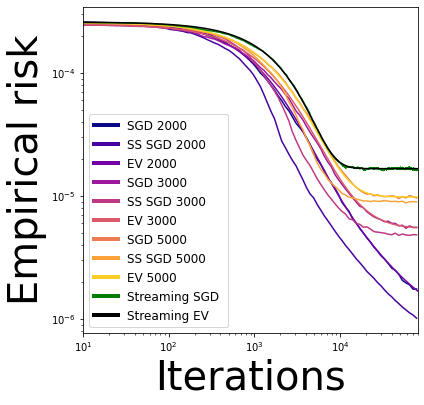

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 3*len(n_mult))))

for (idx,nmult) in enumerate(n_mult):
  n=nmult*n_base
  #print(idx)
  plt.plot(sgdtimes[idx], sgdtrains[idx]/n, label="SGD "+str(n),
           c=next(colors))
  plt.plot(ss_sgdtimes[idx], ss_sgdtrains[idx]/n, label="SS SGD "+str(n),
           c=next(colors))
  plt.plot(tgrids[idx]*nmult*n_base, vemps[idx]/n, label="EV "+str(n),c=next(colors))


plt.plot(s_times, s_train_cs/d, label="Streaming SGD ",
         c='green')
plt.plot(st_grid*d, sv_emp, label="Streaming EV",
         c='black')

plt.xlim([10,t_max])
leg = plt.legend(bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize='12')
#plt.xticks(Fontsize='28')
#plt.yticks(Fontsize='28')
plt.xlabel('Iterations',fontsize='40')
plt.ylabel('Empirical risk',fontsize='40')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

fig.savefig("GaussianLinearRegression_train.pdf")

Gaussian linear regression test loss

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n_grid=10000
n_base = 1000 #datapoints to keep
#n_list = [800, 1600, 3200, 6400, 12800]
#n_mult = [1000,2000,5000,10000,30000,60000]
#n_mult = [5,10]
#t_max = 10000 #iterations
#n_mult = [2,3,5,8,12,16,24]
n_mult = [2,3,5]
t_max = 80000 #iterations
#n_mult = [6,10,16,24,40,60]
#t_max = 600000 #iterations
gamma=0.8
ridge = 0.01
eta = 0.0
os=10 #show os datapoints per epoch


beta = npr.randn(d)/np.sqrt(d)

#nmax = max(n_list)

actual = beta
SigmaPsi = np.eye(d)
u=actual
c=0.5*np.sum(actual**2)
test2loss= lambda x: (0.5)*(np.sum((x - beta)**2)+eta**2)

t_sgdtimes = []
t_sgds= []
t_tgrids = []
t_vemps = []
ss_t_sgdtimes = []
ss_t_sgds= []
ss_t_tgrids = []
ss_t_vemps = []
ss_t_shifts = []


for nmult in n_mult:
    #datapairs
  n = n_base*nmult

  #Data
  A = npr.randn(n,d)/np.sqrt(d)
  b = A@beta + eta*npr.randn(n)/np.sqrt(d)

  #initialization
  ist = np.zeros(d)/np.sqrt(d)


  U, s, Vh = np.linalg.svd(A, full_matrices=False)
  eigs = np.pad(s**2, (0,max(n-d,0)))
  UTb = U.transpose() @ b

  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d:
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  sgd_sol, sgd_test2_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,
                          loss=test2loss,
                          gamma=gamma,
                          oversample='adaptive')
  t_sgdtimes.append(sgd_times)
  t_sgds.append(sgd_test2_cs)

  ss_sgd_sol, ss_sgd_test2_cs, ss_sgd_times = ss_sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,
                          loss=test2loss,
                          gamma=gamma,
                          oversample='adaptive')
  ss_t_sgdtimes.append(ss_sgd_times)
  ss_t_sgds.append(ss_sgd_test2_cs)
  #These are used for the volterra computation
  S = Vh@SigmaPsi@Vh.transpose()
  h = -Vh@u.transpose()

  #Second way of getting the training loss, using the empirical_volterra_g_sgd41
  t_grid, v_emp = tf_empirical_volterra_g_sgd(eigs,t_max//n,n_grid,
                                          Vh@ist,UTb,S,h,c,ridge,
                                          gamma=gamma)
  t_tgrids.append(t_grid)
  t_vemps.append(v_emp)


  eigs = np.ones(d)
  #S = np.eye(d)
  #h = -beta
  #c = 0.5*(np.sum(beta**2))
  #UTb = beta + np.sqrt(n/d)*eta*npr.randn(d)/np.sqrt(d)
  #UTb = np.ones(d)*np.sqrt(1+eta**2)/np.sqrt(d)
  #UTb = 1.0*beta#/np.sqrt(d)#*np.sqrt(1+eta**2)/np.sqrt(d)
  #Utb = beta

  #UTb = np.pad(UTb,(0,1), mode='constant', constant_values=(0,eta))
  #eigs = np.pad(eigs,(0,1), mode='constant', constant_values=(0,0))

  #Second way of getting the training loss, using the empirical_volterra_g_sgd41
  ss_t_tgrid, ss_v_temp, ss_shifts = ss_tf_empirical_volterra_sgd(eigs,t_max//d,n_grid,
                                          ist,beta,eta,n, ridge=0,#d*1.0E-4,
                                          gamma=gamma)
  ss_t_tgrids.append(ss_t_tgrid)
  ss_t_vemps.append(ss_v_temp)
  ss_t_shifts.append(ss_shifts)
#  plt.plot(sgd_times, sgd_test2_cs, label="SGD (c-s) "+str(n),
#          c=next(colors))

#  plt.plot(t_grid*n, v_emp, label="Volterra (c-s) "+str(n),
#          c=next(colors))



#sgd_sol, sgd_train_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
#                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
#plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_as, label="SGD (a-s)",c='green')

#plt.xlim([1000,t_max])
#plt.legend()
#fig.savefig('GLReg_Streaming_bootstrap.pdf')

Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.005128886390227814
kernel norm computed as 0.39914845654489073
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.002559999999999982
kernel norm computed as 0.40124136546894784
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.004159470340118805
kernel norm computed as 0.3993127815633669
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.002559999999999982
kernel norm computed as 0.40124136546894784
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.003584818590099713
kernel norm computed as 0.4002661504122038
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.002559999999999982
kernel norm computed as 0.40124136546894784
will use 11 iterations


In [ ]:
a=np.sqrt(d)
def strlin():
  x = npr.randn(d)/a
  return x, x.dot(beta)+eta*npr.randn()/a

#initialization
ist = np.zeros(d)/np.sqrt(d)
s_sol, s_test_cs, s_times = s_sgd_lsq_ridge( strlin, t_max, ridge=0,#1.0E-4,
             initial_state = ist, loss=lambda x: (1/2)*(np.sum( (x-beta)**2)+eta**2),
             gamma=gamma, oversample='adaptive', m=1.0)

In [ ]:
eigs = np.ones(d)
S = np.eye(d)
h = -beta
c = 0.5*(np.sum(beta**2)+eta**2)
#UTb = np.ones(d)*np.sqrt(1+eta**2)/np.sqrt(d)
UTb = 1.0*beta#/np.sqrt(d)#*np.sqrt(1+eta**2)/np.sqrt(d)
#Utb = beta

UTb = np.pad(UTb,(0,1), mode='constant', constant_values=(0,eta))
eigs = np.pad(eigs,(0,1), mode='constant', constant_values=(0,0))

#Second way of getting the training loss, using the empirical_volterra_g_sgd41
st_tgrid, sv_temp = tf_empirical_volterra_g_sgd(eigs,t_max//d,n_grid,
                                        ist,UTb,S,h,c,ridge=0,#d*1.0E-4,
                                        gamma=gamma)

Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.0025587206396801908
kernel norm computed as 0.4010408450464247
will use 11 iterations


In [ ]:
ss_t_vemps[0]

<tf.Tensor: shape=(10000,), dtype=float64, numpy=array([nan, nan, nan, ..., nan, nan, nan])>

<ipython-input-24-85809ceb2bd6>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


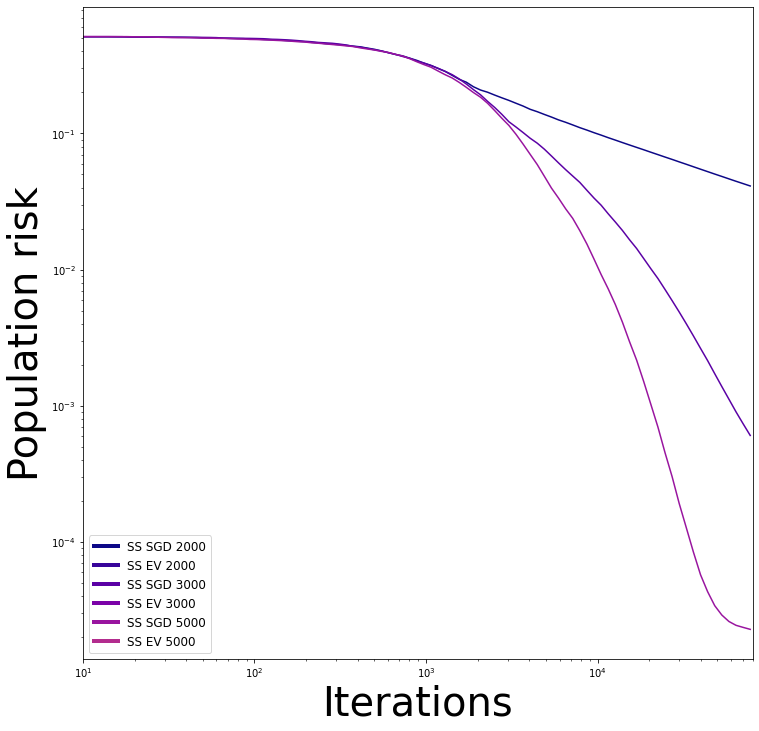

In [ ]:
fig = plt.figure(figsize=(12, 12))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 4*len(n_mult))))

for (idx,nmult) in enumerate(n_mult):
  n=nmult*n_base
  #print(idx)
#  plt.plot(t_sgdtimes[idx], t_sgds[idx], label="SGD "+str(n),
#           c=next(colors))
#  plt.plot(t_tgrids[idx]*nmult*n_base, t_vemps[idx], label="EV "+str(n),c=next(colors))
  plt.plot(ss_t_sgdtimes[idx], ss_t_sgds[idx], label="SS SGD "+str(n),
           c=next(colors))
  plt.plot(ss_t_tgrids[idx]*d, ss_t_vemps[idx], label="SS EV "+str(n),c=next(colors))


#plt.plot(s_times, s_test_cs, label="Streaming SGD ",
#         c='green')
#plt.plot(st_tgrid*d, sv_temp, label="Streaming EV",
#         c='black')

plt.xlim([10,t_max])
leg = plt.legend(bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize='12')
#plt.xticks(Fontsize='28')
#plt.yticks(Fontsize='28')
plt.xlabel('Iterations',fontsize='40')
plt.ylabel('Population risk',fontsize='40')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

fig.savefig("GaussianLinearRegression_test.pdf")

<ipython-input-93-9804b7804f2d>:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


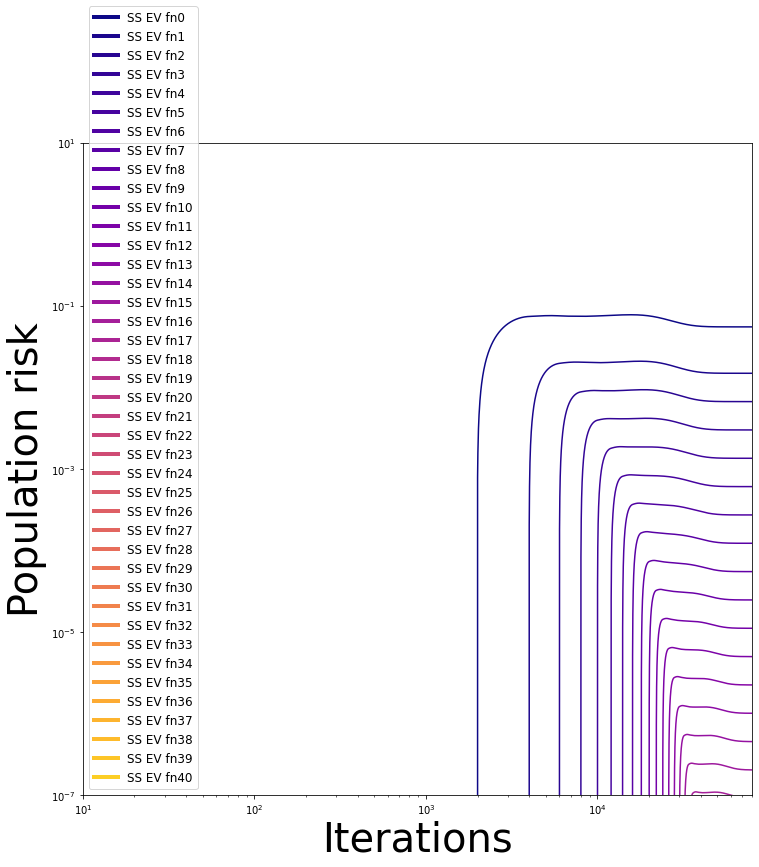

In [ ]:
fig = plt.figure(figsize=(12, 12))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, len(ss_t_shifts[0]))))

for (idx,sss) in enumerate(ss_t_shifts[0]):
  #n=nmult*n_base
  #print(idx)
#  plt.plot(t_sgdtimes[idx], t_sgds[idx], label="SGD "+str(n),
#           c=next(colors))
#  plt.plot(t_tgrids[idx]*nmult*n_base, t_vemps[idx], label="EV "+str(n),c=next(colors))
#  plt.plot(ss_t_sgdtimes[idx], ss_t_sgds[idx], label="SS SGD "+str(n),
#           c=next(colors))
  plt.plot(ss_t_tgrids[0]*d, sss, label="SS EV fn"+str(idx),c=next(colors))


#plt.plot(s_times, s_test_cs, label="Streaming SGD ",
#         c='green')
#plt.plot(st_tgrid*d, sv_temp, label="Streaming EV",
#         c='black')

plt.xlim([10,t_max])
plt.ylim([1E-7,1E1])
leg = plt.legend(bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize='12')
#plt.xticks(Fontsize='28')
#plt.yticks(Fontsize='28')
plt.xlabel('Iterations',fontsize='40')
plt.ylabel('Population risk',fontsize='40')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

fig.savefig("GaussianLinearRegression_test.pdf")

In [ ]:
sv_temp[-1]
ss_t_vemps[1][-1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.033400991485810855>

In [ ]:
from google.colab import files
files.download('GaussianLinearRegression_test.pdf')
files.download('GaussianLinearRegression_train.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MNIST random features regression training loss for even/odd.  Varying the sample size.

Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.015726235934972316
kernel norm computed as 0.4022979655715129
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.016070412379927526
kernel norm computed as 0.40404499829740825
will use 11 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.01589992424684082
kernel norm computed as 0.40432923240626367
will use 11 iterations


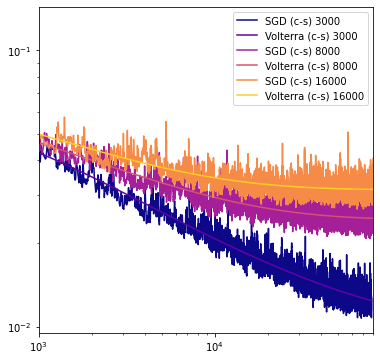

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n_grid=50000
n_base = 1000 #datapoints to keep
#n_list = [800, 1600, 3200, 6400, 12800]
#n_mult = [1000,2000,5000,10000,30000,60000]
#n_mult = [5,10]
#t_max = 10000 #iterations
n_mult = [3,8,16]
t_max = 80000 #iterations
#n_mult = [6,10,16,24,40,60]
#t_max = 600000 #iterations
gamma=0.8
ridge = 0.01

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

#W = tf.random.normal((n0,d),dtype=tf.float32)
W = npr.randn(n0,d)

fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(n_mult))))

#nmax = max(n_list)

for nmult in n_mult:
    #datapairs
  n = n_base*nmult
  b = y_train[0:n] % 2 - 0.5
  X = rescaled_flat[0:n]
  invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
  X = invnorms@X

  #Data
  A = stdz_relu(X@W)/np.sqrt(d)

  #initialization
  ist = np.zeros(d)/np.sqrt(d)

  U, s, Vh = np.linalg.svd(A, full_matrices=False)
  eigs = np.pad(s**2, (0,max(n-d,0)))
  UTb = U.transpose() @ b

  #knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  #if n > d:
  #  UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d:
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  sgd_sol, sgd_train, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,
                          #loss=test2loss,
                          gamma=gamma,
                          oversample='adaptive')

  #These are used for the volterra computation
  #S = Vh@SigmaPsi@Vh.transpose()
  #h = -Vh@u.transpose()

  #Second way of getting the training loss, using the empirical_volterra_g_sgd41
  t_grid, v_emp = tf_empirical_volterra_sgd(eigs,t_max//n,n_grid,
                                          Vh@ist,UTb,ridge,
                                          gamma=gamma)
#  t_grid, v_emp = tf_empirical_volterra_g_sgd(eigs,t_max//n,n_grid,
#                                          Vh@ist,UTb,S,h,c,ridge,
#                                          gamma=gamma)

  plt.plot(sgd_times, sgd_train/n, label="SGD (c-s) "+str(n),
          c=next(colors))

  plt.plot(t_grid*n, v_emp/n, label="Volterra (c-s) "+str(n),
          c=next(colors))


#sgd_sol, sgd_train_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
#                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
#plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_as, label="SGD (a-s)",c='green')

plt.xlim([1000,t_max])
plt.legend()

In [ ]:
from google.colab import files
fig.savefig('MNIST_RF_SGD_Train_d2k_iter600k.pdf')
files.download('MNIST_RF_SGD_Train_d2k_iter600k.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MNIST Validation Test error

Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.0942980064946664
kernel norm computed as 0.4515845150979991
will use 12 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.10173979504797588
kernel norm computed as 0.455668218866096
will use 12 iterations
Danger Will Robinson.  Increase Volterra bins. Your kernel bin maximum is 0.1046681838448671
kernel norm computed as 0.4560201591046121
will use 12 iterations


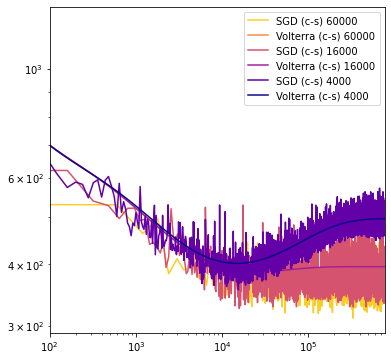

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n_base = 1000 #datapoints to keep
#n_list = [800, 1600, 3200, 6400, 12800]
#n_mult = [1000,2000,5000,10000,30000,60000]
#n_mult = [2,4,8,16,32]
n_mult = [60,16,4]
t_max = 768000 #iterations
ensembling = 1
#n_mult = [1,2,5,10,30,60]
#t_max = 600000 #iterations
gamma=0.8
ridge = 0.01
os=100    #show os datapoints per epoch
n_grid=t_max//10

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

W = npr.randn(n0,d)

#initialize figure
test2fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
colors = iter(plt.cm.plasma(np.linspace(0.9, 0.0, 2*len(n_mult))))


#Compute test loss parameters
flat_test = x_test.reshape(10000,28*28)
flat_test = scaler.transform(flat_test)
inorms=sp.sparse.diags(1/np.linalg.norm(flat_test,axis=1))
flat_test = inorms@flat_test
actual = ((y_test[0:10000] % 2) - 0.5)
TA = (stdz_relu(flat_test@W)/np.sqrt(d))
SigmaPsi = TA.transpose() @ TA
u=actual.transpose()@TA
c=0.5*np.sum(actual**2)
test2loss= lambda x: (0.5)*(x.transpose()@SigmaPsi@x)+c-u@x


for nmult in n_mult:
  sgdruns = []
  evruns = []
  for j in range(ensembling):
      #datapairs
    n = n_base*nmult
    sset = npr.choice(60000,n,replace=False)
    b = (y_train[sset] % 2 - 0.5)
    X = rescaled_flat[sset]
    invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
    X = invnorms@X

    #Data
    A = stdz_relu(X@W)/np.sqrt(d)

    #initialization
    ist = np.zeros(d)/np.sqrt(d)

    U, s, Vh = np.linalg.svd(A, full_matrices=False)
    eigs = np.pad(s**2, (0,max(n-d,0)))


    UTb = U.transpose() @ b
    knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
    if n > d:
      UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

    sgd_sol, sgd_test2_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,
                            loss=test2loss,
                            gamma=gamma,
                            oversample=os)
    sgdruns.append(sgd_test2_cs)

    #These are used for the volterra computation
  S = Vh@SigmaPsi@Vh.transpose()
  h = -Vh@u.transpose()

  #Second way of getting the training loss, using the empirical_volterra_g_sgd41
  t_grid, v_emp = tf_empirical_volterra_g_sgd(eigs,t_max//n,n_grid,
                                          Vh@ist,UTb,S,h,c,ridge,
                                          gamma=gamma)
#  evruns.append(v_emp)

  avgtest = np.mean(sgdruns,axis=0)
  plt.plot(sgd_times, avgtest, label="SGD (c-s) "+str(n),
          c=next(colors))

#  avgev = np.mean(evruns,axis=0)
  plt.plot(t_grid*n, v_emp, label="Volterra (c-s) "+str(n),
          c=next(colors))


#sgd_sol, sgd_train_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
#                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
#plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_as, label="SGD (a-s)",c='green')

plt.xlim([100,t_max])
plt.legend()

In [ ]:
test2fig.savefig("MNIST_Volterra_RF_d2000_L2generalization.pdf")
from google.colab import files
files.download('MNIST_Volterra_RF_d2000_L2generalization.pdf')

NameError: ignored

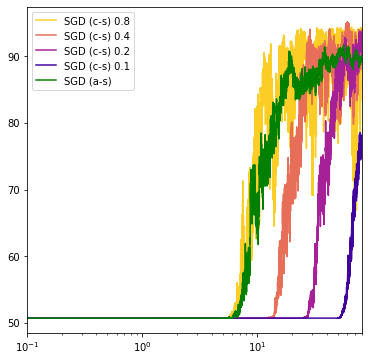

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 16000 #datapoints to keep
t_max = 80
gamma_list = [0.8,0.4,0.2,0.1]
ridge = 0.01
os=100 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)
b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)



X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = npr.randn(n0,d)

flat_test = x_test.reshape(10000,28*28)
flat_test =scaler.transform(flat_test)
actual = (y_test[0:10000] % 2) > 0
TA = (stdz_relu(flat_test@W)/np.sqrt(d))
testloss=lambda x: (np.sum(((TA@ x) > 0) == actual)/100)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))

UTb = U.transpose() @ b
knorm = np.sqrt(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2)
if n > d:
  UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )


testfig = plt.figure(figsize=(6, 6))
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0.9, 0.1, len(gamma_list))))

for gamma in gamma_list:
  sgd_sol, sgd_test_cs = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                        loss = testloss,
                                        initial_state=ist,gamma=gamma,oversample=os)
  plt.plot(np.linspace(0,t_max,t_max*os), sgd_test_cs, label="SGD (c-s) "+str(gamma),
           c=next(colors))
  #t_grid, v_emp = empirical_volterra_sgd(eigs,t_max,n_grid,Vh@ist,UTb,ridge,gamma)
  #plt.plot(t_grid, v_emp, label="EV (c-s)",c=next(colors))


sgd_sol, sgd_test_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                          loss=testloss,
                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
plt.plot(np.linspace(0,t_max,t_max*os), sgd_test_as, label="SGD (a-s)",c='green')

plt.xlim([0.1,t_max])
plt.legend()

In [ ]:
max(sgd_test_as)

96.08

MNIST L2 test error, with Volterra comparison

kernel norm computed as 0.05036660432733887
will use 4 iterations
kernel norm computed as 0.10056772540241225
will use 5 iterations
kernel norm computed as 0.20077989530173163
will use 6 iterations
kernel norm computed as 0.40108352609113124
will use 11 iterations


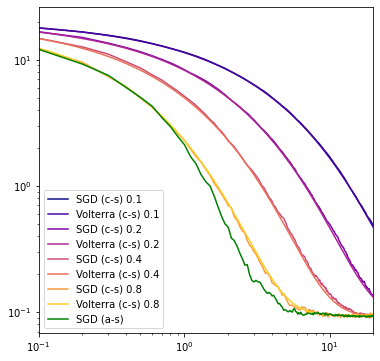

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 16000 #datapoints to keep
t_max = 20
n_grid=1000
gamma_list = [0.1,0.2,0.4,0.8]
ridge = 0.01
os=10 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)

X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = npr.randn(n0,d)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

#Compute eigendecomposition of target
U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))
eigs = eigs[0:n]

UTb = U.transpose() @ b
knorm = np.sqrt(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2)
if n > d:
  UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

#initialize figure
test2fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(gamma_list))))


#Compute test loss parameters
flat_test = x_test.reshape(10000,28*28)
flat_test =scaler.transform(flat_test)
invnorms_test=sp.sparse.diags(1/np.linalg.norm(flat_test,axis=1))
flat_test = invnorms_test@flat_test
actual = ((y_test[0:10000] % 2) - 0.5)/np.sqrt(10000)
TA = (stdz_relu(flat_test@W)/np.sqrt(d)/np.sqrt(10000))
SigmaPsi = TA.transpose() @ TA
u=actual.transpose()@TA
c=0.5*np.sum(actual**2)
test2loss= lambda x: (0.5)*(x.transpose()@SigmaPsi@x)+c-u@x

#These are used for the volterra computation
S = Vh@SigmaPsi@Vh.transpose()
h = -Vh@u.transpose()

for gamma in gamma_list:
  sgd_test2_cs = sgd_lsq_ridge(A,b,t_max,ridge=ridge,initial_state=ist,
                          loss=test2loss,
                          gamma=gamma,
                          oversample=os)[1]
  plt.plot(np.linspace(0,t_max,t_max*os), sgd_test2_cs, label="SGD (c-s) "+str(gamma),
           c=next(colors))
  #Second way of getting the training loss, using the empirical_volterra_g_sgd
  t_grid, v_emp = empirical_volterra_g_sgd(eigs,t_max,n_grid,
                                           Vh@ist,UTb,S,h,c,ridge,
                                           gamma=gamma)
  plt.plot(t_grid, v_emp, label="Volterra (c-s) "+str(gamma),
           c=next(colors))

sgd_sol, sgd_test_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                          loss=test2loss,
                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
plt.plot(np.linspace(0,t_max,t_max*os), sgd_test_as, label="SGD (a-s)",c='green')

plt.xlim([0.1,t_max])
plt.legend()

In [ ]:
from google.colab import files
fig.savefig('MNIST_RF_SGD_Train_dXn_2kX16k_t20.pdf')
testfig.savefig('MNIST_RF_SGD_Validation_dXn_2kX16k_t20.pdf')
test2fig.savefig('MNIST_RF_SGD_L2Train_dXn_2kX16k_t20.pdf')
files.download('MNIST_RF_SGD_Train_dXn_2kX16k_t20.pdf')
files.download('MNIST_RF_SGD_Validation_dXn_2kX16k_t20.pdf')
files.download('MNIST_RF_SGD_L2Train_dXn_2kX16k_t20.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 4000 #datapoints to keep
t_max = 20
n_grid=1000
gamma_list = [0.1,0.2,0.4,0.8]
ridge = 0.01
os=10 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)

X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = npr.randn(n0,d)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

#Compute eigendecomposition of target
U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))
eigs = eigs[0:n]

plt.hist(eigs[eigs>0.1],bins=100,density=True)
#a = eigs[eigs < 2]
#plt.plot(np.log(np.sort(a)), np.log(np.linspace(0, 1, len(a), endpoint=False)))


In [ ]:
print(min(s**2))
print(max(s**2))
print(np.sum(s**2)/4000.)

0.017536024372953835
295.62384684348035
1.0005804256469233
